In [6]:
import pandas as pd

# Upload the dataset using Colab's built-in function
from google.colab import files
uploaded = files.upload()


Saving diabetes.csv to diabetes.csv


In [7]:
train_df = pd.read_csv('diabetes.csv')
train_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
# Replace zeros with np.nan in all columns except 'Outcome'
import numpy as np
columns_to_exclude = ['Outcome']
for col in train_df.columns:
    if col not in columns_to_exclude:
        train_df[col].replace(0, np.nan, inplace=True)

In [9]:
train_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1.0,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8.0,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,NaN,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [10]:
print(train_df.isna().sum())


Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [11]:
numerical_cols = [col for col in train_df.columns
                    if (train_df[col].dtype == 'float64' or train_df[col].dtype == 'int64') and train_df[col].isnull().sum() > 0]
numerical_cols

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [12]:
skewness = train_df[numerical_cols].skew()
print(skewness)


Pregnancies      0.885535
Glucose          0.530989
BloodPressure    0.134153
SkinThickness    0.690619
Insulin          2.166464
BMI              0.593970
dtype: float64


In [13]:
for col in numerical_cols:
    if skewness[col] < -0.5 or skewness[col] > 0.5:
        # Use median for imputation
        train_df[col].fillna(train_df[col].median(), inplace=True)
    else:
        # Use mean for imputation
        train_df[col].fillna(train_df[col].mean(), inplace=True)
print(train_df.isna().sum())


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


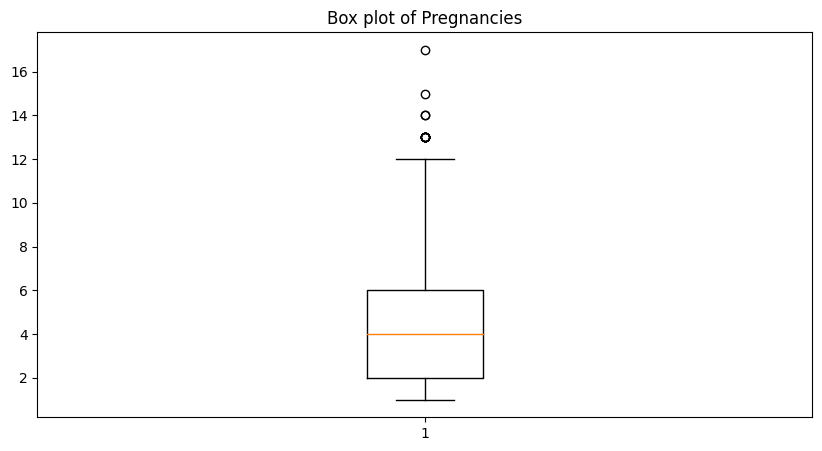

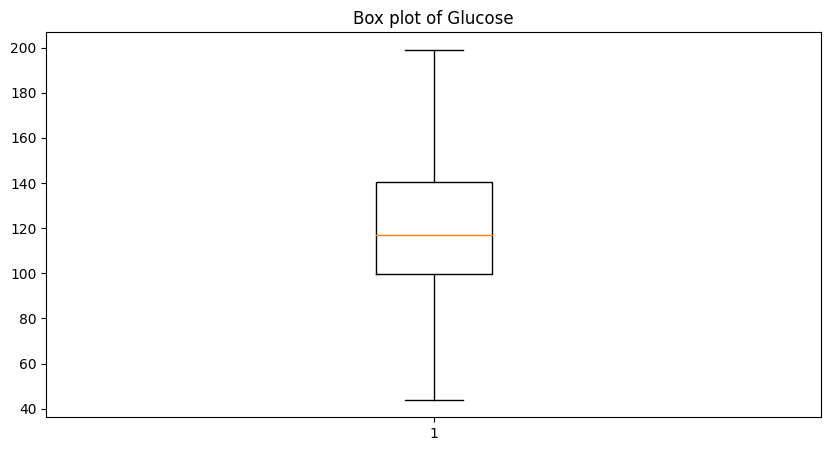

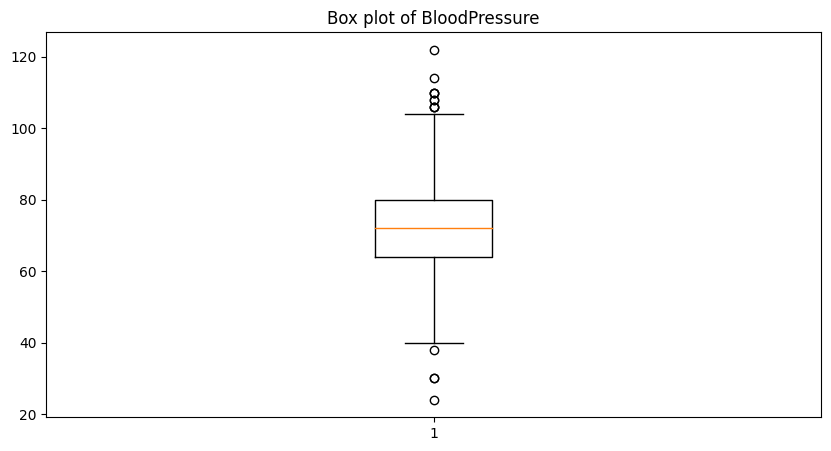

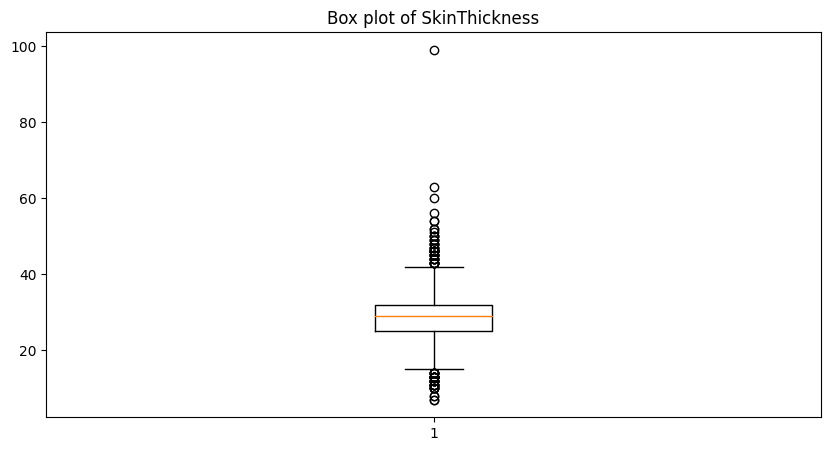

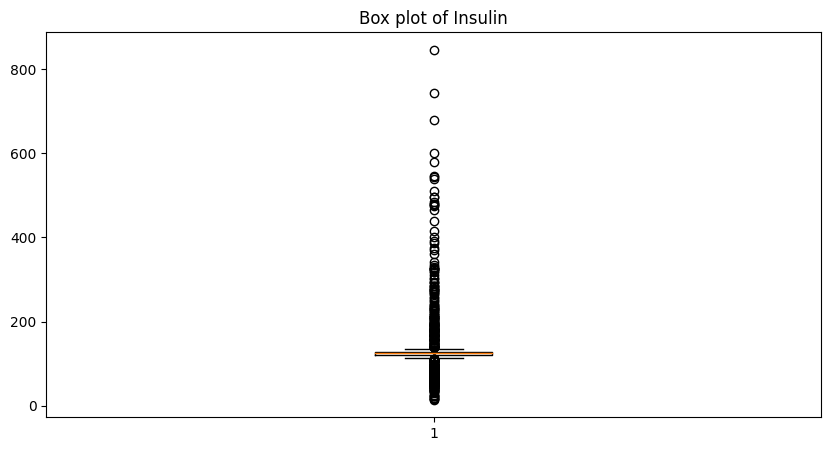

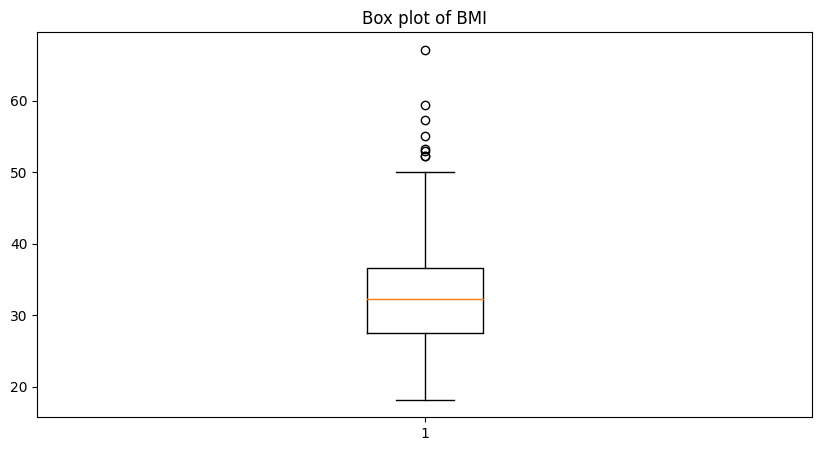

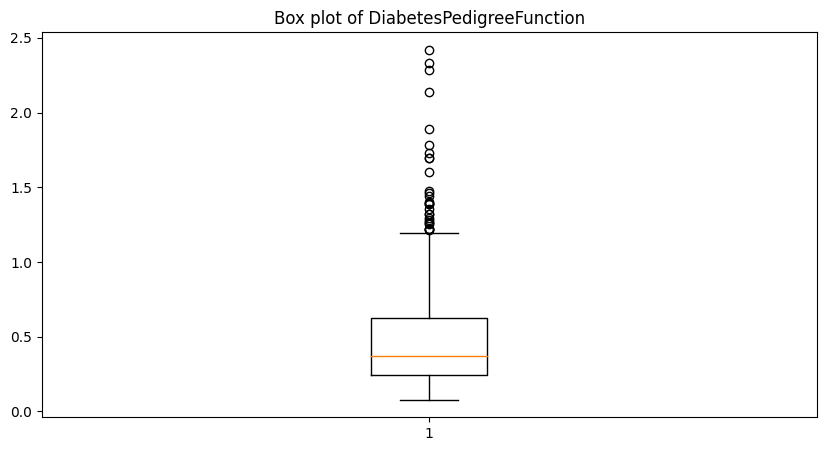

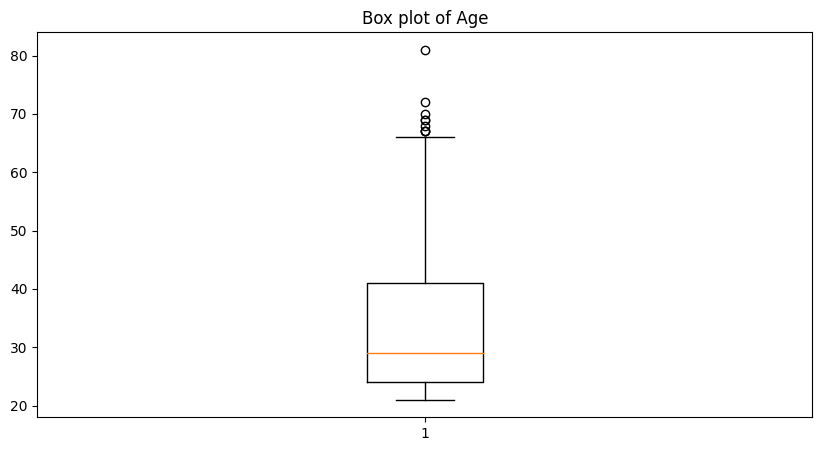

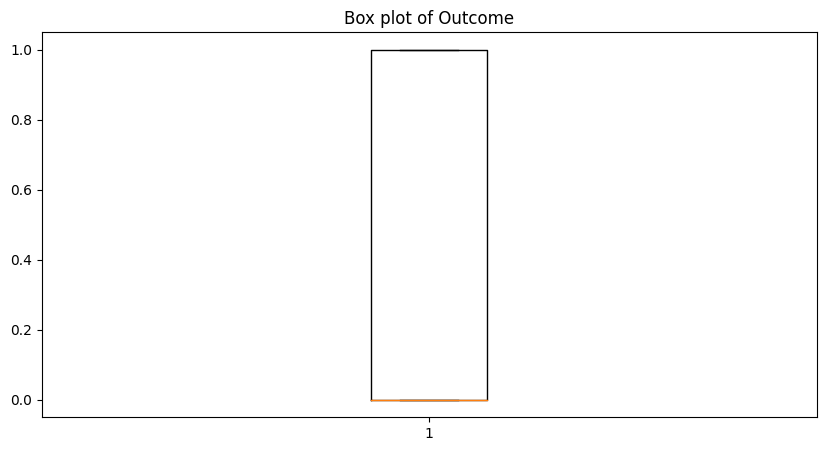

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_cols = [col for col in train_df.columns if train_df[col].dtype == 'float64' or train_df[col].dtype == 'int64']

for col in numerical_cols:
    plt.figure(figsize=(10, 5))
    plt.boxplot(x=train_df[col])
    plt.title(f'Box plot of {col}')
    plt.show()


In [15]:
def outlier_percentage(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    percentage = (outliers.shape[0] / df.shape[0]) * 100
    return percentage

numerical_cols = [col for col in train_df.columns if train_df[col].dtype == 'float64' or train_df[col].dtype == 'int64']

outlier_percentages = {}
for col in numerical_cols:
    outlier_percentages[col] = outlier_percentage(train_df, col)

# Display the result
for col, percentage in outlier_percentages.items():
    print(f"{col}: {percentage:.2f}%")


Pregnancies: 1.82%
Glucose: 0.00%
BloodPressure: 1.82%
SkinThickness: 11.33%
Insulin: 45.05%
BMI: 1.04%
DiabetesPedigreeFunction: 3.78%
Age: 1.17%
Outcome: 0.00%


In [16]:
def cap_outliers_using_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].apply(lambda x: upper_bound if x > upper_bound else x)
    df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else x)
    return df

numerical_cols = [col for col in train_df.columns if train_df[col].dtype == 'float64' or train_df[col].dtype == 'int64']

for col in numerical_cols:
    train_df = cap_outliers_using_iqr(train_df, col)
outlier_percentages = {}
for col in numerical_cols:
    outlier_percentages[col] = outlier_percentage(train_df, col)

# Display the result
for col, percentage in outlier_percentages.items():
    print(f"{col}: {percentage:.2f}%")


Pregnancies: 0.00%
Glucose: 0.00%
BloodPressure: 0.00%
SkinThickness: 0.00%
Insulin: 0.00%
BMI: 0.00%
DiabetesPedigreeFunction: 0.00%
Age: 0.00%
Outcome: 0.00%


In [17]:
# Filter categorical columns if any

categorical_cols = train_df.select_dtypes(include=['object']).columns
categorical_cols
# Print unique values for each categorical column
for col in categorical_cols:
    print(f"{col}: {train_df[col].unique()}")


In [18]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoders = {}
one_hot_encoders = {}  # Store our one-hot encoders here

# Split columns into those that need label encoding and those that need one-hot encoding
label_encode_cols = [col for col in train_df.columns if train_df[col].dtype == 'object' and train_df[col].nunique() <= 3]
one_hot_encode_cols = [col for col in train_df.columns if train_df[col].dtype == 'object' and train_df[col].nunique() > 3]

# Apply label encoding
for col in label_encode_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    label_encoders[col] = le

# Apply one-hot encoding
ohe = OneHotEncoder(drop='first', sparse=False)

if one_hot_encode_cols:
    train_encoded = ohe.fit_transform(train_df[one_hot_encode_cols])
    train_encoded_df = pd.DataFrame(train_encoded, columns=ohe.get_feature_names_out(one_hot_encode_cols))


    # Drop original columns and add the one-hot encoded columns
    train_df.drop(one_hot_encode_cols, axis=1, inplace=True)
    train_df = pd.concat([train_df, train_encoded_df], axis=1)

    one_hot_encoders = ohe


In [19]:
train_df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,125.000,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,125.000,26.6,0.351,31.0,0
2,8.0,183.0,64.0,29.0,125.000,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,112.875,28.1,0.167,21.0,0
4,4.0,137.0,40.0,35.0,135.875,43.1,1.200,33.0,1


In [20]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler
scaler = MinMaxScaler()

# Exclude the target column
feature_columns = [col for col in train_df.columns if col != 'Outcome']

# Scale the features in the training data
data_scaled = train_df.copy()
data_scaled[feature_columns] = scaler.fit_transform(data_scaled[feature_columns])

data_scaled.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.454545,0.670968,0.50000,0.732143,0.527174,0.480499,0.489305,0.637363,1
1,0.000000,0.264516,0.40625,0.517857,0.527174,0.262090,0.243316,0.219780,0
2,0.636364,0.896774,0.37500,0.517857,0.527174,0.159126,0.529412,0.241758,1
3,0.000000,0.290323,0.40625,0.303571,0.000000,0.308892,0.079323,0.000000,0
4,0.272727,0.600000,0.00000,0.732143,1.000000,0.776911,1.000000,0.263736,1


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [25]:
X = data_scaled.drop('Outcome', axis=1)
y = data_scaled['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [29]:

# List to store model info
model_info = []

best_model = None
best_accuracy = 0
best_params = None

# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
model_info.append({'Model': 'Logistic Regression', 'Accuracy': accuracy, 'Parameters': log_reg.get_params()})
if accuracy >= best_accuracy:
    best_model = 'Logistic Regression'
    best_accuracy = accuracy
    best_params = log_reg.get_params()

# k-NN
for k in range(3, 16):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_info.append({'Model': f'KNN, k={k}', 'Accuracy': accuracy, 'Parameters': knn.get_params()})
    if accuracy >= best_accuracy:
        best_model = f'KNN, k={k}'
        best_accuracy = accuracy
        best_params = knn.get_params()

# SVM
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for kernel in kernels:
    svc = SVC(kernel=kernel)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_info.append({'Model': f'SVM, kernel={kernel}', 'Accuracy': accuracy, 'Parameters': svc.get_params()})
    if accuracy >= best_accuracy:
        best_model = f'SVM, kernel={kernel}'
        best_accuracy = accuracy
        best_params = svc.get_params()

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
model_info.append({'Model': 'Random Forest', 'Accuracy': accuracy, 'Parameters': rf.get_params()})
if accuracy >= best_accuracy:
    best_model = 'Random Forest'
    best_accuracy = accuracy
    best_params = rf.get_params()

# Print all model info
for info in model_info:
    print(f"Model: {info['Model']}, Accuracy: {info['Accuracy']}, Parameters: {info['Parameters']}")


Model: Logistic Regression, Accuracy: 0.7467532467532467, Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Model: KNN, k=3, Accuracy: 0.7012987012987013, Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Model: KNN, k=4, Accuracy: 0.7272727272727273, Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 4, 'p': 2, 'weights': 'uniform'}
Model: KNN, k=5, Accuracy: 0.7272727272727273, Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Model: KNN, k=6, Accuracy: 0.

In [30]:

# Print best model
print(f"\nThe best model is {best_model} with an accuracy of {best_accuracy}")
print(f"Parameters: {best_params}")


The best model is Random Forest with an accuracy of 0.7662337662337663
Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
